# Spoiler Alert.

This notebook comprises of techniques and analysis steps we used to tackle the problem of spoiler in user reviews. We have approached it in two ways:
1. Classification using simple traditional machine learning algorithms.
2. State of the art algorithm, Deep Learning.

The dataset can be found in kaggle following this link: [Dataset](https://www.kaggle.com/rmisra/imdb-spoiler-dataset)



In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))

import sys

import pandas as pd
import numpy as np
import operator
import string
import nltk

import pandas 
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/IMDB_spoiler_dataset/'

In [ ]:
# Insert the directory to import custom modules
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/nlp')

In [ ]:
train_data = pd.read_json(path + 'IMDB_reviews.json', lines=True)

In [ ]:
print(train_data.shape)
train_data.head()

(573913, 7)


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [ ]:
print(train_data["review_text"][0])
print("======================== IS SPOILER ===================")
print(train_data["is_spoiler"][0])

In its Oscar year, Shawshank Redemption (written and directed by Frank Darabont, after the novella Rita Hayworth and the Shawshank Redemption, by Stephen King) was nominated for seven Academy Awards, and walked away with zero. Best Picture went to Forrest Gump, while Shawshank and Pulp Fiction were "just happy to be nominated." Of course hindsight is 20/20, but while history looks back on Gump as a good film, Pulp and Redemption are remembered as some of the all-time best. Pulp, however, was a success from the word "go," making a huge splash at Cannes and making its writer-director an American master after only two films. For Andy Dufresne and Co., success didn't come easy. Fortunately, failure wasn't a life sentence.After opening on 33 screens with take of $727,327, the $25M film fell fast from theatres and finished with a mere $28.3M. The reasons for failure are many. Firstly, the title is a clunker. While iconic to fans today, in 1994, people knew not and cared not what a 'Shawshank

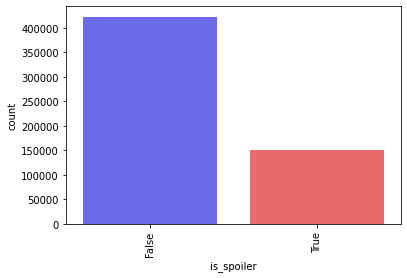

In [ ]:
sns.countplot(x=train_data.is_spoiler, order=[x for x, count in sorted(Counter(train_data.is_spoiler).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

Now as we can see above, we have more than `500000` reviews yet we have an imbalanced dataset. This creates a problem specifically in classification tasks called **Accuracy Paradox**. This is the case when a simple model may have a high level of accuracy but be too crude to be useful. For example, if the incidence of category A is dominant, being found in 99% of cases, then predicting that every case is category A will have an accuracy of 99%; which translates to our model might flag reviews as **non-spoilers** most of the time.

To take care of class imbalance we have different techniques:
- We can look for different datasets with similar data and append the data of lower class with the additional data from different datasets in order to make it more balanced. 

- Balance the data using oversampling technique

- While splitting Train and Test data, we can give the stratify parameter the output column that we are trying to predict, so that they show a balanced distribution on the train and test set

- We can also give `class_weights` as a parameter to our model's fit method

The solution we went with was having some threshold and get an eqaul balance of both our cases, spoiler and non-spoiler. Apart from solving the class imbalance issue, the reason we chose this was, when we choose the stratifying method and used the whole dataset, preprocessing and training times were super long which took most of our time working on the project. For this reason we minimized our dataset size to 200000 reviews.

In [ ]:
spoiler_data = train_data[train_data["is_spoiler"]==True][:100000]
non_spoiler_data = train_data[train_data["is_spoiler"]==False][:100000]

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#Combine spoiler and non_spoiler dataset
all_data = pd.concat([spoiler_data, non_spoiler_data], ignore_index=True)

# Shuffle data
all_data = all_data.sample(frac=1)

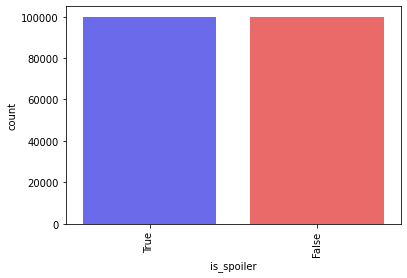

In [ ]:
sns.countplot(x=all_data.is_spoiler, order=[x for x, count in sorted(Counter(all_data.is_spoiler).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

Perfect, now that we have a balanced and adequate amount of training corpus. The next step is preprocessing and some analysis on our reviews. 

In one of our forums we have seen that, by plotting the most repeated words in each class we expected to see the words "most representative" of each class. If they were different enough, this will indicate us that we can use them to easily to identify the classes.

In [ ]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"review_text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["review_text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "review_text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.review_text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

In [ ]:
from nltk.stem import *
from nltk.corpus import stopwords

import re

def process_text(raw_text):

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]
    
    return( " ".join( stemmed ))  

In [ ]:
all_data['clean_text'] = all_data['review_text'].apply(lambda x: process_text(x))
plot_most_common_features(all_data.clean_text, all_data.is_spoiler)

Looks like we have many common words and it's a bit vague to see which words are the most representative of our classes. We also know that we need to take care of special characters and punctuations in our corpus.

In [ ]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!:.\/'+-=]", " ", text)

    return text

In [ ]:
def process_text(raw_text):
    
    # raw_text = text_to_word_list(raw_text)
    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english"))  
    not_stop_words = [w for w in words if not w in stops]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]
    
    return( " ".join( stemmed )) 

In [ ]:
all_data['clean_text'] = all_data['review_text'].apply(lambda x: process_text(x))
plot_most_common_features(all_data.clean_text, all_data.is_spoiler)

##  Train Test Split.

We have seen earlier that most of the words are similar, but we can understand if a review is a spoiler or not depending on it's context and information contained. Can this intelligence refelected by our ML models? Let's see. We'll start by splitting our data to train and test set.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data[["clean_text"]], all_data[["is_spoiler"]],
                                                    stratify=all_data[["is_spoiler"]], 
                                                    test_size=0.2)

In [ ]:
# Hot encoding for the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train.is_spoiler.values)
target_labels = le.classes_
encoded_y_train = le.transform(y_train.is_spoiler.values)
encoded_y_test = le.transform(y_test.is_spoiler.values)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
le_name_mapping

{False: 0, True: 1}

In [ ]:
count_vect = CountVectorizer(analyzer = "word")
train_features = count_vect.fit_transform(X_train['clean_text'])
test_features = count_vect.transform(X_test['clean_text'])

tfidf = TfidfTransformer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(train_features)
test_text_tfidf_features = tfidf.fit_transform(test_features)      

In [ ]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given labeled data using accuracy."""
    
    # Cross validation
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
      
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 0)
    
    # Train the model over and tune the parameters
    print("Training model")
    grid_search.fit(X, yt)

    # CV-score
    print("Best score: %0.3f" % grid_search.best_score_)
    if len(grid) > 0:
      best_parameters = grid_search.best_estimator_.get_params()
      print("Best parameters set: ")
      print(best_parameters)
        

    return grid_search

## Naïve Bayes

In [ ]:
nb_text_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, MultinomialNB(), {})

Training model
Best score: 0.808


In [ ]:
nb_text_cls.score(test_text_tfidf_features, encoded_y_test)

0.804

Not bad! We have best score of 80% on the test data. Let's see how our model performs when we give it a direct inpute from the user.

In [ ]:
def predict(text, model):
  text_feature = count_vect.transform(text)
  text_tfidf_feature = tfidf.fit_transform(text_feature)
  
  pred = model.predict(text_tfidf_feature)
  # print custom response
  if (pred.item()==1):
      print("Spoiler!")
  elif (pred.item()==0):
      print("Not Spoiler!")

In [ ]:
text = "Spoiler Alert! probabl best action film time ingredi consid best best first back ultim movi spectacular f x action sequenc nowaday movi look date still manag shock surreal nightmarish post apocalyt set monstruou robot action f x great great best thing movi termin spend lot effort fantast plot charact develop need extrem use f x charact interest background realli get plot simpli great futurist tale involv end world hand technolog time war human machin action non stop let want enough arnold co spectacular gun amaz explos memor chase sequenc freeway motorcycl etc movi rank high fun factor entertain factor arnold schwarzenegg deliv kickass perform everi time say hasta la vista babi problema trademark line skin crawl part pop cultur fit perfect movi feel linda hamilton sexi hell deliv brave solid perform special mention edward furlong deliv great perform robert patrick steal show villain impress jame cameron creat one best movi time bring us best possibl action ever seen movi also room gloriou gore non stop violenc els much say truli recommend everyon one movi chang point view toward cinema"

In [ ]:
predict([text], nb_text_cls)

Spoiler!


## Linear Regression

In [ ]:
# LR model
from sklearn.linear_model import LogisticRegression

lr_text_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, LogisticRegression(random_state=42), {})

Training model
Best score: 0.809


In [ ]:
text = "This is spoiler review! Jon Snow kills dany in the end season of GOT"

In [ ]:
predict([text], lr_text_cls)

Spoiler!


In [ ]:
lr_text_cls.score(test_text_tfidf_features, encoded_y_test)

0.80825

It's obvious that our two models give comparable results. Not let's move on to a more sophisticated solution using deep learning. This will be also the model we'll try to deploy in aws for our web app.

# Deep Learning

Now that we have seen a simple yet robust classification algorithms, it's time to use state of the art technology specifically tailored for this kind of problems, Recurrent Neural Network (RNN). **Recurrent Neural Network** is a generalization of feedforward neural network that has an internal memory. RNN is recurrent in nature as it performs the same function for every input of data while the output of the current input depends on the past one computation. After producing the output, it is copied and sent back into the recurrent network. For making a decision, it considers the current input and the output that it has learned from the previous input. The temporal dependency of RNNs is what makes them ideal in langauage processing specially LSTMs. **Long Short-Term Memory (LSTM)** networks are a modified version of recurrent neural networks, which makes it easier to remember past data in memory. The vanishing gradient problem of RNN is also resolved here. LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. 

Now we have a little bit background let's dive into the fun part. :)

In [ ]:
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X = all_data['review_text']
y = list(map(lambda x: 0 if x==False else 1, all_data['is_spoiler']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
X_train.head()

59512     I'm 18 years old now and Tolkien's Middle-Eart...
97693     This movie is unbelievably bad or, rather, sup...
175009    The third and last part of the Bourne trilogy ...
149870    This movie is spectacular. Chinatown has one o...
193689    Summer blockbuster season always brings with i...
Name: review_text, dtype: object

The first step in processing the reviews is to make sure that any symbols or tags that appear should be removed. In addition we wish to tokenize our input, that way words such as *entertained* and *entertaining* are considered the same with regard to sentiment analysis. The `review_to_words` method defined above uses the nltk package to tokenize the reviews.

In [ ]:
from nltk.stem.porter import *


def review_to_words(review):
  stemmer = PorterStemmer()

  text = str(review)
  text = text.lower()

  text = re.sub(r"[^A-Za-z0-9^,!:.\/'+-=]", " ", text)

  words = text.split()
  words = [w for w in words if w not in stopwords.words("english")]
  words = [PorterStemmer().stem(w) for w in words]

  return words


The method below applies the `review_to_words` method to each of the reviews in the training and testing datasets. In addition it caches the results. This is because performing this processing step can take a long time. This way if you are unable to complete the notebook in the current session, you can come back without needing to process the data a second time.

In [ ]:
import pickle

cache_dir = os.path.join("/content/drive/My Drive/Colab Notebooks/nlp/cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [ ]:
# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(X_train, X_test, y_train, y_test)

Read preprocessed data from cache file: preprocessed_data.pkl


## Transform the data

For the next step in this notebook we will construct a feature representation called bag-of-words. To start, we will represent each word as an integer. Of course, some of the words that appear in the reviews occur very infrequently and so likely don't contain much information for the purposes of the review analysis. The way we will deal with this problem is that we will fix the size of our working vocabulary and we will only include the words that appear most frequently. We will then combine all of the infrequent words into a single category and, in our case, we will label it as 1.

Since we will be using a recurrent neural network, it will be convenient if the length of each review is the same. To do this, we will fix a size for our reviews and then pad short reviews with the category 'no word' (which we will label 0) and truncate long reviews.

To begin with, we need to construct a way to map words that appear in the reviews to integers. Here we fix the size of our vocabulary (including the 'no word' and 'infrequent' categories) to be `5000` but you may wish to change this to see how it affects the model.

 Note that even though the vocab_size is set to 5000, we only want to construct a mapping for the most frequently appearing 4998 words. This is because we want to reserve the special labels `0` for 'no word' and `1` for 'infrequent word'.

In [ ]:
import numpy as np

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    # sentence is a list of words.
    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur
    
    for review in data:
        for word in review:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
    # Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    # sorted_words[-1] is the least frequently appearing word.
    
    sorted_words = None
    sorted_words = sorted(word_count, key=word_count.get, reverse=True)
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word' and
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [ ]:
word_dict = build_dict(X_train)

In [ ]:
count = 0
for word in word_dict:
    print(word)
    if count > 4:
        break
    count += 1

movi
film
like
one
make
see


## Transform the reviews

Now that we have our word dictionary which allows us to transform the words appearing in the reviews into integers, it is time to make use of it and convert our reviews to their integer sequence representation, making sure to pad or truncate to a fixed length, which in our case is `500`.

In [ ]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [ ]:
X_train, X_train_len = convert_and_pad_data(word_dict, X_train)
X_test, X_test_len = convert_and_pad_data(word_dict, X_test)

In [ ]:
# Use this cell to examine one of the processed reviews to make sure everything is working as intended.
X_train[100]

array([   1, 2901,  597,    1,    1,  324,  135,   57,   64,  576,   31,
         14,    9, 1104,  196,  524,   12,   67,  225,  275,  161,  888,
         43,    2,   97,    1,  743,  736,  743,  700,  454,  147,  727,
       1773,  467,   55,  460,   83,    1, 2563,  135,   46,    1,    1,
        808,  199,  672,  144, 2569, 2569,  530,    1, 2252, 4061,  284,
         73,    2,    1,    6,    1,  533,  456,    2,   48,   14,   15,
        147,   77, 1693,    1,    2, 1067,  430,  292, 1643,    1,  135,
       1668, 3390,  147,   20,    1, 2431,  147,    4,    1,    1,    1,
          1, 2909,   23,  397,    1,  264,   39, 4029,  112,    1,    1,
        224,   66,   43,  841,    1, 3923,  134, 4335,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Save the processed training dataset locally
It is important to note the format of the data that we are saving as we will need to know it when we write the training code. In our case, each row of the dataset has the form `label`, `length`, `review[500]` where `review[500]` is a sequence of `500` integers representing the words in the review.

In [ ]:
pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train_len), pd.DataFrame(X_train)], axis=1) \
        .to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

First we will load a small portion of the training data set to use as a sample. It would be very time consuming to try and train the model completely in the notebook as we do not have access to a powerful computing instance which inturn increases the time it takes to train the whole sample. However, we can work on a small bit of the data to get a feel for how our training script is behaving.

In [ ]:
import torch
import torch.utils.data

# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=250)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

In [ ]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            out = model.forward(batch_X)
            loss = loss_fn(out, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))

    return model

In [ ]:
import torch.optim as optim
from train.model import LSTMClassifier
embedding_dim = 32
hidden_dim = 100
vocab_size = 5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(embedding_dim, hidden_dim, vocab_size).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

trained_model = train(model, train_sample_dl, 30, optimizer, loss_fn, device)

Epoch: 1, BCELoss: 0.6925389885902404
Epoch: 2, BCELoss: 0.6850505590438842
Epoch: 3, BCELoss: 0.6786375403404236
Epoch: 4, BCELoss: 0.6711050629615783
Epoch: 5, BCELoss: 0.6607265591621398
Epoch: 6, BCELoss: 0.6444045662879944
Epoch: 7, BCELoss: 0.6185956716537475
Epoch: 8, BCELoss: 0.5854316234588623
Epoch: 9, BCELoss: 0.5512206196784973
Epoch: 10, BCELoss: 0.505123770236969
Epoch: 11, BCELoss: 0.4544136881828308
Epoch: 12, BCELoss: 0.40600094199180603
Epoch: 13, BCELoss: 0.36829398274421693
Epoch: 14, BCELoss: 0.33865317702293396
Epoch: 15, BCELoss: 0.3641043663024902
Epoch: 16, BCELoss: 0.3139317035675049
Epoch: 17, BCELoss: 0.3262467384338379
Epoch: 18, BCELoss: 0.28491824865341187
Epoch: 19, BCELoss: 0.21986788809299468
Epoch: 20, BCELoss: 0.19498106241226196
Epoch: 21, BCELoss: 0.22358021438121795
Epoch: 22, BCELoss: 0.17137837409973145
Epoch: 23, BCELoss: 0.15338201224803924
Epoch: 24, BCELoss: 0.10329500585794449
Epoch: 25, BCELoss: 0.09225806444883347
Epoch: 26, BCELoss: 0.07

## Saving the trained model.

After training for a while we saved our trained model including the parameters and settings. This is particularly useful for two main reasons:
1. If it takes to much time to train our model and we want to continue training at a later time.
2. We are particularly interested in the inference or the end result with out going through the whole preprocessing and training steps.

**NOTE**: So if anyone is using this code they can start from this step and test our model using some review texts.

In [ ]:
checkpoint = {'model': LSTMClassifier(32, 100, 5000),
              'state_dict': trained_model.state_dict(),
              'optimizer' : optimizer.state_dict(),
              'word_dict': trained_model.word_dict}


# Save trained model and parameters.
torch.save(checkpoint, 'spoiler_alert_model.pth')

In [ ]:
# Load our saved model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [ ]:
model = load_checkpoint('spoiler_alert_model.pth')
print(model)

LSTMClassifier(
  (embedding): Embedding(5000, 32, padding_idx=0)
  (lstm): LSTM(32, 100)
  (dense): Linear(in_features=100, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
def predict_fn(input_data, model, word_dict):
    print('Inferring review of input data.')

    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the saved word_dict.
    word_dict_path = os.path.join('/content/drive/My Drive/Colab Notebooks/nlp/data/pytorch', 'word_dict.pkl')
    with open(word_dict_path, 'rb') as f:
        model.word_dict = pickle.load(f)
        
    if model.word_dict is None:
        raise Exception('Model has not been loaded properly, no word_dict.')
    
    # Process input_data so that it is ready to be sent to our model.
    # You should produce two variables:
    # data_X   - A sequence of length 500 which represents the converted review
    # data_len - The length of the review

    data_X, data_len = convert_and_pad(model.word_dict, review_to_words(input_data))

    # Using data_X and data_len we construct an appropriate input tensor. Remember
    # that our model expects input data of the form 'len, review[500]'.
    data_pack = np.hstack((data_len, data_X))
    data_pack = data_pack.reshape(1, -1)
    
    data = torch.from_numpy(data_pack)
    # data = data.to(device)

    # Make sure to put the model into evaluation mode
    model.eval()

    # Compute the result of applying the model to the input data. The variable `result` should
    # be a numpy array which contains a single integer which is either 1 or 0

    with torch.no_grad():
        out = model.forward(data)

    if np.round(out.numpy()) == 1:
      result = "Spoiler!"
    else:
      result = "Not Spoiler!"    
    # result = np.round(out.numpy())


    return result

In [ ]:
test_review = "Call this 1999 teenage version of Pulp Fiction whatever you want but please don't call it original. This is one of the worst Tarantino rip-offs I have ever seen. The first two stories are mindless and un-entertaining. The only redeeming value the movie had was some of the humor contained in the last story. I noticed that a lot of IMDB users have complemented the acting in this film; I have to disagree. The acting, especially among some of the younger characters, was either dry, silly, or overdone. 3/10"

In [ ]:
print(predict_fn(test_review, model, word_dict))

Inferring review of input data.
Not Spoiler!
